In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageFile
import itertools
import optuna
from itertools import product

### Data Preprocessing 

In [2]:
data = pd.read_csv('CV-research\datasets\FracAtlas\dataset.csv')

In [3]:
data.head(2)

,image_id,hand,leg,hip,shoulder,mixed,hardware,multiscan,fractured,fracture_count,frontal,lateral,oblique
0,IMG0000000.jpg,0,1,0,0,0,0,1,0,0,1,1,0
1,IMG0000001.jpg,0,1,0,0,0,0,1,0,0,1,1,0


In [4]:
base_path = 'CV-research\datasets\FracAtlas\images'
fractured_path = os.path.join(base_path, 'Fractured')
non_fractured_path = os.path.join(base_path, 'Non_fractured')
non_fractured_path

'/kaggle/input/fracatlas/FracAtlas/images/Non_fractured'

In [5]:
image_paths = {img: os.path.join(fractured_path, img) for img in os.listdir(fractured_path)}
image_paths.update({img: os.path.join(non_fractured_path, img) for img in os.listdir(non_fractured_path)})

In [6]:
data_directory = 'CV-research\datasets\FracAtlas\images'
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:
# This makes PIL ignore bytes beyond the truncation point
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Custom loader that uses PIL and ignores errors in truncated images
def custom_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
        
dataset = datasets.ImageFolder(root=data_directory, transform=transform, loader=custom_loader)


### Train Test Val Split (70:15:15)

In [8]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
validation_size = int(0.15 * total_size)
test_size = total_size - train_size - validation_size

In [9]:
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, validation_size, test_size]
)

In [10]:
# train_loader = DataLoader(train_dataset, batch_size= 32, shuffle= True)
# val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size= 32)

### Transfer Learning

In [11]:
def modify_model(model,dropout_rate,num_classes=2):
    if hasattr(model, 'fc'):
        num_ftrs = model.fc.in_features
        model._fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, num_classes)
        )
    elif hasattr(model, 'classifier'):  # DenseNet
        if isinstance(model.classifier, nn.Sequential):
            *layers, last_layer = model.classifier.children()
            num_ftrs = last_layer.in_features
            new_last_layer = nn.Linear(num_ftrs, num_classes)
            model.classifier = nn.Sequential(*layers, new_last_layer)
        else:
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, num_classes)
    else:
        raise Exception("Unknown model architecture")
    return model

### Train model Function

In [12]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct = 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
        for inputs, labels in train_bar:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

            train_bar.set_postfix(loss=total_loss / (total_correct + 1))

        train_accuracy = total_correct / len(train_dataset)

        model.eval()
        val_correct = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
        with torch.no_grad():
            for inputs, labels in val_bar:
                outputs = model(inputs)
                val_correct += (outputs.argmax(1) == labels).sum().item()

                val_bar.set_postfix(accuracy=val_correct / (len(val_dataset) + 1))

        val_accuracy = val_correct / len(val_dataset)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    return model, best_val_accuracy


### Using Bayesian Optimization and Optuna Framework for optimized Hyperparameter Tuning 

In [13]:
optuna.logging.set_verbosity(optuna.logging.INFO)

In [14]:
def objective(trial):
    # Hyperparameters to be tuned by Optuna
    lr = trial.suggest_float("lr", 0.001, 0.01, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    epochs = trial.suggest_categorical("epochs", [2, 3])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.5)
    weight_decay = trial.suggest_float("weight_decay", 0.001, 0.01, log=True)
    
    print(f"\nTrial {trial.number}: Testing with lr: {lr}, batch_size: {batch_size}, epochs: {epochs}, optimizer: {optimizer_name}, dropout_rate: {dropout_rate}, weight_decay: {weight_decay}")

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model setup
    model = models.efficientnet_b0(pretrained=True)
    model = modify_model(model, dropout_rate)

    # Optimizer setup
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    trained_model, best_val_accuracy = train_model(model, criterion, optimizer, train_loader, val_loader, epochs)

    return best_val_accuracy


In [15]:
study = optuna.create_study(direction="maximize")


[I 2023-12-03 03:03:58,225] A new study created in memory with name: no-name-af7fa42e-c785-42e3-9e4c-0e2d1d9d8cb2


In [16]:
study.optimize(objective, n_trials=25)


Trial 0: Testing with lr: 0.003265773933060471, batch_size: 32, epochs: 2, optimizer: Adam, dropout_rate: 0.31097997755668483, weight_decay: 0.0054863956980904325


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 50.2MB/s]
Epoch 1/2 [Validation]: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it, accuracy=0.824]


Epoch 1/2, Train Loss: 42.9833, Train Acc: 0.8097, Val Acc: 0.8252


Epoch 2/2 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s, accuracy=0.824]
[I 2023-12-03 03:15:29,344] Trial 0 finished with value: 0.8251633986928104 and parameters: {'lr': 0.003265773933060471, 'batch_size': 32, 'epochs': 2, 'optimizer': 'Adam', 'dropout_rate': 0.31097997755668483, 'weight_decay': 0.0054863956980904325}. Best is trial 0 with value: 0.8251633986928104.


Epoch 2/2, Train Loss: 39.1138, Train Acc: 0.8230, Val Acc: 0.8252

Trial 1: Testing with lr: 0.009361289023973032, batch_size: 64, epochs: 2, optimizer: SGD, dropout_rate: 0.45284985232006614, weight_decay: 0.0018121227208665273


Epoch 1/2 [Validation]: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it, accuracy=0.827]


Epoch 1/2, Train Loss: 21.3598, Train Acc: 0.8118, Val Acc: 0.8284


Epoch 2/2 [Validation]: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it, accuracy=0.834]
[I 2023-12-03 03:30:59,481] Trial 1 finished with value: 0.8349673202614379 and parameters: {'lr': 0.009361289023973032, 'batch_size': 64, 'epochs': 2, 'optimizer': 'SGD', 'dropout_rate': 0.45284985232006614, 'weight_decay': 0.0018121227208665273}. Best is trial 1 with value: 0.8349673202614379.


Epoch 2/2, Train Loss: 18.5182, Train Acc: 0.8282, Val Acc: 0.8350

Trial 2: Testing with lr: 0.005344111388260649, batch_size: 32, epochs: 3, optimizer: Adam, dropout_rate: 0.3718424255208225, weight_decay: 0.0022192310303244707


Epoch 1/3 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s, accuracy=0.824]


Epoch 1/3, Train Loss: 47.0300, Train Acc: 0.8013, Val Acc: 0.8252


Epoch 2/3 [Validation]: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it, accuracy=0.824]


Epoch 2/3, Train Loss: 42.2905, Train Acc: 0.8219, Val Acc: 0.8252


Epoch 3/3 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s, accuracy=0.824]
[I 2023-12-03 03:49:23,134] Trial 2 finished with value: 0.8251633986928104 and parameters: {'lr': 0.005344111388260649, 'batch_size': 32, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.3718424255208225, 'weight_decay': 0.0022192310303244707}. Best is trial 1 with value: 0.8349673202614379.


Epoch 3/3, Train Loss: 41.2505, Train Acc: 0.8216, Val Acc: 0.8252

Trial 3: Testing with lr: 0.0010789550706640405, batch_size: 32, epochs: 3, optimizer: Adam, dropout_rate: 0.3041337422983703, weight_decay: 0.0031225058950810182


Epoch 1/3 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s, accuracy=0.809]


Epoch 1/3, Train Loss: 34.7835, Train Acc: 0.8387, Val Acc: 0.8105


Epoch 2/3 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s, accuracy=0.868]


Epoch 2/3, Train Loss: 28.9358, Train Acc: 0.8726, Val Acc: 0.8693


Epoch 3/3 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s, accuracy=0.829]
[I 2023-12-03 04:07:45,109] Trial 3 finished with value: 0.869281045751634 and parameters: {'lr': 0.0010789550706640405, 'batch_size': 32, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.3041337422983703, 'weight_decay': 0.0031225058950810182}. Best is trial 3 with value: 0.869281045751634.


Epoch 3/3, Train Loss: 28.5343, Train Acc: 0.8863, Val Acc: 0.8301

Trial 4: Testing with lr: 0.004587480828169698, batch_size: 32, epochs: 3, optimizer: Adam, dropout_rate: 0.34714505173567667, weight_decay: 0.0010180813841738176


Epoch 1/3 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s, accuracy=0.825]


Epoch 1/3, Train Loss: 44.8201, Train Acc: 0.8034, Val Acc: 0.8268


Epoch 2/3 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s, accuracy=0.847]


Epoch 2/3, Train Loss: 38.3966, Train Acc: 0.8321, Val Acc: 0.8480


Epoch 3/3 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s, accuracy=0.838]
[I 2023-12-03 04:26:00,498] Trial 4 finished with value: 0.8480392156862745 and parameters: {'lr': 0.004587480828169698, 'batch_size': 32, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.34714505173567667, 'weight_decay': 0.0010180813841738176}. Best is trial 3 with value: 0.869281045751634.


Epoch 3/3, Train Loss: 36.8045, Train Acc: 0.8397, Val Acc: 0.8399

Trial 5: Testing with lr: 0.004260604436702781, batch_size: 32, epochs: 2, optimizer: Adam, dropout_rate: 0.49562742032811424, weight_decay: 0.004231275786535848


Epoch 1/2 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s, accuracy=0.824]


Epoch 1/2, Train Loss: 48.2894, Train Acc: 0.8027, Val Acc: 0.8252


Epoch 2/2 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s, accuracy=0.824]
[I 2023-12-03 04:38:11,069] Trial 5 finished with value: 0.8251633986928104 and parameters: {'lr': 0.004260604436702781, 'batch_size': 32, 'epochs': 2, 'optimizer': 'Adam', 'dropout_rate': 0.49562742032811424, 'weight_decay': 0.004231275786535848}. Best is trial 3 with value: 0.869281045751634.


Epoch 2/2, Train Loss: 47.8306, Train Acc: 0.8055, Val Acc: 0.8252

Trial 6: Testing with lr: 0.001999415265403182, batch_size: 32, epochs: 3, optimizer: SGD, dropout_rate: 0.44420408862293226, weight_decay: 0.005731773881635043


Epoch 1/3 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s, accuracy=0.824]


Epoch 1/3, Train Loss: 45.7397, Train Acc: 0.8086, Val Acc: 0.8252


Epoch 2/3 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s, accuracy=0.824]


Epoch 2/3, Train Loss: 39.8613, Train Acc: 0.8261, Val Acc: 0.8252


Epoch 3/3 [Validation]: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s, accuracy=0.829]
[I 2023-12-03 04:56:29,768] Trial 6 finished with value: 0.8300653594771242 and parameters: {'lr': 0.001999415265403182, 'batch_size': 32, 'epochs': 3, 'optimizer': 'SGD', 'dropout_rate': 0.44420408862293226, 'weight_decay': 0.005731773881635043}. Best is trial 3 with value: 0.869281045751634.


Epoch 3/3, Train Loss: 37.6262, Train Acc: 0.8265, Val Acc: 0.8301

Trial 7: Testing with lr: 0.0013566195842156985, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.3752649657764261, weight_decay: 0.0030322708344055383


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.92s/it, accuracy=0.824]


Epoch 1/3, Train Loss: 17.2813, Train Acc: 0.8513, Val Acc: 0.8252


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:31<00:00,  3.19s/it, accuracy=0.878]


Epoch 2/3, Train Loss: 11.9809, Train Acc: 0.8989, Val Acc: 0.8791


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:31<00:00,  3.19s/it, accuracy=0.856]
[I 2023-12-03 05:21:23,975] Trial 7 finished with value: 0.8790849673202614 and parameters: {'lr': 0.0013566195842156985, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.3752649657764261, 'weight_decay': 0.0030322708344055383}. Best is trial 7 with value: 0.8790849673202614.


Epoch 3/3, Train Loss: 11.9048, Train Acc: 0.9020, Val Acc: 0.8578

Trial 8: Testing with lr: 0.0010940718049249382, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.3997769483219211, weight_decay: 0.0010549073040323383


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:30<00:00,  3.01s/it, accuracy=0.858]


Epoch 1/3, Train Loss: 16.9360, Train Acc: 0.8439, Val Acc: 0.8595


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:30<00:00,  3.01s/it, accuracy=0.871]


Epoch 2/3, Train Loss: 11.8071, Train Acc: 0.8971, Val Acc: 0.8725


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:30<00:00,  3.07s/it, accuracy=0.863]
[I 2023-12-03 05:46:56,615] Trial 8 finished with value: 0.8725490196078431 and parameters: {'lr': 0.0010940718049249382, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.3997769483219211, 'weight_decay': 0.0010549073040323383}. Best is trial 7 with value: 0.8790849673202614.


Epoch 3/3, Train Loss: 9.9907, Train Acc: 0.9160, Val Acc: 0.8644

Trial 9: Testing with lr: 0.002747973463119634, batch_size: 32, epochs: 2, optimizer: Adam, dropout_rate: 0.44784328291360653, weight_decay: 0.005756813129067723


Epoch 1/2 [Validation]: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it, accuracy=0.824]


Epoch 1/2, Train Loss: 41.0559, Train Acc: 0.8086, Val Acc: 0.8252


Epoch 2/2 [Validation]: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it, accuracy=0.812]
[I 2023-12-03 06:00:41,180] Trial 9 finished with value: 0.8251633986928104 and parameters: {'lr': 0.002747973463119634, 'batch_size': 32, 'epochs': 2, 'optimizer': 'Adam', 'dropout_rate': 0.44784328291360653, 'weight_decay': 0.005756813129067723}. Best is trial 7 with value: 0.8790849673202614.


Epoch 2/2, Train Loss: 41.6486, Train Acc: 0.8212, Val Acc: 0.8137

Trial 10: Testing with lr: 0.0016313171701409128, batch_size: 64, epochs: 3, optimizer: SGD, dropout_rate: 0.35946070359345605, weight_decay: 0.00699397659942561


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:28<00:00,  2.88s/it, accuracy=0.824]


Epoch 1/3, Train Loss: 25.8759, Train Acc: 0.7547, Val Acc: 0.8252


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.90s/it, accuracy=0.824]


Epoch 2/3, Train Loss: 21.0611, Train Acc: 0.8254, Val Acc: 0.8252


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:28<00:00,  2.81s/it, accuracy=0.822]
[I 2023-12-03 06:26:26,355] Trial 10 finished with value: 0.8251633986928104 and parameters: {'lr': 0.0016313171701409128, 'batch_size': 64, 'epochs': 3, 'optimizer': 'SGD', 'dropout_rate': 0.35946070359345605, 'weight_decay': 0.00699397659942561}. Best is trial 7 with value: 0.8790849673202614.


Epoch 3/3, Train Loss: 19.9258, Train Acc: 0.8254, Val Acc: 0.8235

Trial 11: Testing with lr: 0.0010050342147979782, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.3989674606912388, weight_decay: 0.0010571586415863427


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:27<00:00,  2.78s/it, accuracy=0.86]


Epoch 1/3, Train Loss: 16.8200, Train Acc: 0.8411, Val Acc: 0.8611


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it, accuracy=0.724]


Epoch 2/3, Train Loss: 11.5947, Train Acc: 0.9010, Val Acc: 0.7255


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:28<00:00,  2.83s/it, accuracy=0.883]
[I 2023-12-03 06:51:36,416] Trial 11 finished with value: 0.8839869281045751 and parameters: {'lr': 0.0010050342147979782, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.3989674606912388, 'weight_decay': 0.0010571586415863427}. Best is trial 11 with value: 0.8839869281045751.


Epoch 3/3, Train Loss: 8.0694, Train Acc: 0.9367, Val Acc: 0.8840

Trial 12: Testing with lr: 0.001025206876036553, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.4013194816793953, weight_decay: 0.001724989464529551


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:30<00:00,  3.10s/it, accuracy=0.869]


Epoch 1/3, Train Loss: 17.0024, Train Acc: 0.8383, Val Acc: 0.8709


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:27<00:00,  2.75s/it, accuracy=0.817]


Epoch 2/3, Train Loss: 11.4101, Train Acc: 0.9038, Val Acc: 0.8186


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:27<00:00,  2.75s/it, accuracy=0.881]
[I 2023-12-03 07:16:23,213] Trial 12 finished with value: 0.8823529411764706 and parameters: {'lr': 0.001025206876036553, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.4013194816793953, 'weight_decay': 0.001724989464529551}. Best is trial 11 with value: 0.8839869281045751.


Epoch 3/3, Train Loss: 9.1647, Train Acc: 0.9199, Val Acc: 0.8824

Trial 13: Testing with lr: 0.0010188474839838762, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.41261542706472015, weight_decay: 0.0014687203450751405


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:48<00:00,  4.85s/it, accuracy=0.866]


Epoch 1/3, Train Loss: 16.1589, Train Acc: 0.8527, Val Acc: 0.8676


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:28<00:00,  2.80s/it, accuracy=0.853]


Epoch 2/3, Train Loss: 10.8913, Train Acc: 0.9129, Val Acc: 0.8546


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:27<00:00,  2.76s/it, accuracy=0.874]
[I 2023-12-03 07:42:17,847] Trial 13 finished with value: 0.8758169934640523 and parameters: {'lr': 0.0010188474839838762, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.41261542706472015, 'weight_decay': 0.0014687203450751405}. Best is trial 11 with value: 0.8839869281045751.


Epoch 3/3, Train Loss: 9.0388, Train Acc: 0.9262, Val Acc: 0.8758

Trial 14: Testing with lr: 0.0015609579261277545, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.4010145174207654, weight_decay: 0.0014558672357934661


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it, accuracy=0.856]


Epoch 1/3, Train Loss: 17.7350, Train Acc: 0.8345, Val Acc: 0.8578


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:27<00:00,  2.71s/it, accuracy=0.853]


Epoch 2/3, Train Loss: 12.8467, Train Acc: 0.8912, Val Acc: 0.8546


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:27<00:00,  2.73s/it, accuracy=0.871]
[I 2023-12-03 08:06:43,547] Trial 14 finished with value: 0.8725490196078431 and parameters: {'lr': 0.0015609579261277545, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.4010145174207654, 'weight_decay': 0.0014558672357934661}. Best is trial 11 with value: 0.8839869281045751.


Epoch 3/3, Train Loss: 11.9641, Train Acc: 0.8926, Val Acc: 0.8725

Trial 15: Testing with lr: 0.0020179775269165384, batch_size: 64, epochs: 3, optimizer: SGD, dropout_rate: 0.4132006831255096, weight_decay: 0.002098177056944591


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it, accuracy=0.824]


Epoch 1/3, Train Loss: 25.5244, Train Acc: 0.7526, Val Acc: 0.8252


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:27<00:00,  2.79s/it, accuracy=0.821]


Epoch 2/3, Train Loss: 20.9726, Train Acc: 0.8233, Val Acc: 0.8219


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:28<00:00,  2.81s/it, accuracy=0.822]
[I 2023-12-03 08:31:39,284] Trial 15 finished with value: 0.8251633986928104 and parameters: {'lr': 0.0020179775269165384, 'batch_size': 64, 'epochs': 3, 'optimizer': 'SGD', 'dropout_rate': 0.4132006831255096, 'weight_decay': 0.002098177056944591}. Best is trial 11 with value: 0.8839869281045751.


Epoch 3/3, Train Loss: 20.0538, Train Acc: 0.8261, Val Acc: 0.8235

Trial 16: Testing with lr: 0.0013271290759725735, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.3347834004912931, weight_decay: 0.001314559525118245


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:28<00:00,  2.82s/it, accuracy=0.863]


Epoch 1/3, Train Loss: 17.1355, Train Acc: 0.8488, Val Acc: 0.8644


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:27<00:00,  2.79s/it, accuracy=0.869]


Epoch 2/3, Train Loss: 12.3162, Train Acc: 0.8940, Val Acc: 0.8709


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:28<00:00,  2.82s/it, accuracy=0.878]
[I 2023-12-03 08:56:33,702] Trial 16 finished with value: 0.8790849673202614 and parameters: {'lr': 0.0013271290759725735, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.3347834004912931, 'weight_decay': 0.001314559525118245}. Best is trial 11 with value: 0.8839869281045751.


Epoch 3/3, Train Loss: 10.6618, Train Acc: 0.9045, Val Acc: 0.8791

Trial 17: Testing with lr: 0.0010168126363681535, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.3834631111887453, weight_decay: 0.009101895957120722


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.93s/it, accuracy=0.333]


Epoch 1/3, Train Loss: 16.8088, Train Acc: 0.8418, Val Acc: 0.3333


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:28<00:00,  2.81s/it, accuracy=0.68] 


Epoch 2/3, Train Loss: 12.9970, Train Acc: 0.8866, Val Acc: 0.6814


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:28<00:00,  2.82s/it, accuracy=0.853]
[I 2023-12-03 09:21:43,479] Trial 17 finished with value: 0.8545751633986928 and parameters: {'lr': 0.0010168126363681535, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.3834631111887453, 'weight_decay': 0.009101895957120722}. Best is trial 11 with value: 0.8839869281045751.


Epoch 3/3, Train Loss: 11.8095, Train Acc: 0.9045, Val Acc: 0.8546

Trial 18: Testing with lr: 0.0017796918691982571, batch_size: 64, epochs: 2, optimizer: SGD, dropout_rate: 0.4270442757932386, weight_decay: 0.0012504168013731229


Epoch 1/2 [Validation]: 100%|██████████| 10/10 [00:28<00:00,  2.87s/it, accuracy=0.822]


Epoch 1/2, Train Loss: 26.1805, Train Acc: 0.7334, Val Acc: 0.8235


Epoch 2/2 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.99s/it, accuracy=0.824]
[I 2023-12-03 09:38:46,078] Trial 18 finished with value: 0.8251633986928104 and parameters: {'lr': 0.0017796918691982571, 'batch_size': 64, 'epochs': 2, 'optimizer': 'SGD', 'dropout_rate': 0.4270442757932386, 'weight_decay': 0.0012504168013731229}. Best is trial 11 with value: 0.8839869281045751.


Epoch 2/2, Train Loss: 21.4881, Train Acc: 0.8233, Val Acc: 0.8252

Trial 19: Testing with lr: 0.0013476461915396623, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.3813583394805154, weight_decay: 0.0016670305972545359


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.94s/it, accuracy=0.863]


Epoch 1/3, Train Loss: 17.2999, Train Acc: 0.8387, Val Acc: 0.8644


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.98s/it, accuracy=0.821]


Epoch 2/3, Train Loss: 12.2747, Train Acc: 0.8912, Val Acc: 0.8219


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:30<00:00,  3.01s/it, accuracy=0.869]
[I 2023-12-03 10:04:52,874] Trial 19 finished with value: 0.8709150326797386 and parameters: {'lr': 0.0013476461915396623, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.3813583394805154, 'weight_decay': 0.0016670305972545359}. Best is trial 11 with value: 0.8839869281045751.


Epoch 3/3, Train Loss: 11.3204, Train Acc: 0.9066, Val Acc: 0.8709

Trial 20: Testing with lr: 0.002155845652032898, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.3400882222370678, weight_decay: 0.00231126777877817


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:30<00:00,  3.05s/it, accuracy=0.759]


Epoch 1/3, Train Loss: 17.9117, Train Acc: 0.8380, Val Acc: 0.7598


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.93s/it, accuracy=0.845]


Epoch 2/3, Train Loss: 14.6557, Train Acc: 0.8737, Val Acc: 0.8464


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.91s/it, accuracy=0.824]
[I 2023-12-03 10:31:10,587] Trial 20 finished with value: 0.8464052287581699 and parameters: {'lr': 0.002155845652032898, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.3400882222370678, 'weight_decay': 0.00231126777877817}. Best is trial 11 with value: 0.8839869281045751.


Epoch 3/3, Train Loss: 13.7335, Train Acc: 0.8796, Val Acc: 0.8252

Trial 21: Testing with lr: 0.0013356152947763707, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.37205554791312995, weight_decay: 0.002768120217829627


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.97s/it, accuracy=0.863]


Epoch 1/3, Train Loss: 17.4184, Train Acc: 0.8338, Val Acc: 0.8644


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.97s/it, accuracy=0.863]


Epoch 2/3, Train Loss: 13.1172, Train Acc: 0.8852, Val Acc: 0.8644


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.92s/it, accuracy=0.798]
[I 2023-12-03 10:57:05,549] Trial 21 finished with value: 0.8643790849673203 and parameters: {'lr': 0.0013356152947763707, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.37205554791312995, 'weight_decay': 0.002768120217829627}. Best is trial 11 with value: 0.8839869281045751.


Epoch 3/3, Train Loss: 11.8038, Train Acc: 0.8943, Val Acc: 0.7990

Trial 22: Testing with lr: 0.0013126006236480353, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.39218828552488494, weight_decay: 0.0035643383440612784


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.97s/it, accuracy=0.861]


Epoch 1/3, Train Loss: 17.6585, Train Acc: 0.8394, Val Acc: 0.8627


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.99s/it, accuracy=0.861]


Epoch 2/3, Train Loss: 13.3270, Train Acc: 0.8964, Val Acc: 0.8627


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.96s/it, accuracy=0.843]
[I 2023-12-03 11:23:19,200] Trial 22 finished with value: 0.8627450980392157 and parameters: {'lr': 0.0013126006236480353, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.39218828552488494, 'weight_decay': 0.0035643383440612784}. Best is trial 11 with value: 0.8839869281045751.


Epoch 3/3, Train Loss: 12.1670, Train Acc: 0.8936, Val Acc: 0.8448

Trial 23: Testing with lr: 0.0010072607928631393, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.3645120744679374, weight_decay: 0.001813661081238927


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.97s/it, accuracy=0.879]


Epoch 1/3, Train Loss: 16.2580, Train Acc: 0.8488, Val Acc: 0.8807


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.92s/it, accuracy=0.878]


Epoch 2/3, Train Loss: 10.7841, Train Acc: 0.9073, Val Acc: 0.8791


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:30<00:00,  3.02s/it, accuracy=0.865]
[I 2023-12-03 11:49:27,235] Trial 23 finished with value: 0.880718954248366 and parameters: {'lr': 0.0010072607928631393, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.3645120744679374, 'weight_decay': 0.001813661081238927}. Best is trial 11 with value: 0.8839869281045751.


Epoch 3/3, Train Loss: 7.8135, Train Acc: 0.9367, Val Acc: 0.8660

Trial 24: Testing with lr: 0.0010132871056769358, batch_size: 64, epochs: 3, optimizer: Adam, dropout_rate: 0.3576682724703681, weight_decay: 0.0017735262281052737


Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.95s/it, accuracy=0.84] 


Epoch 1/3, Train Loss: 16.6912, Train Acc: 0.8432, Val Acc: 0.8415


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.99s/it, accuracy=0.869]


Epoch 2/3, Train Loss: 11.9462, Train Acc: 0.9027, Val Acc: 0.8709


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:28<00:00,  2.88s/it, accuracy=0.84] 
[I 2023-12-03 12:15:33,451] Trial 24 finished with value: 0.8709150326797386 and parameters: {'lr': 0.0010132871056769358, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.3576682724703681, 'weight_decay': 0.0017735262281052737}. Best is trial 11 with value: 0.8839869281045751.


Epoch 3/3, Train Loss: 10.1777, Train Acc: 0.9143, Val Acc: 0.8415


### Best Hyperparameters

In [17]:
print("Best Hyperparameters: ", study.best_trial.params)

Best Hyperparameters:  {'lr': 0.0010050342147979782, 'batch_size': 64, 'epochs': 3, 'optimizer': 'Adam', 'dropout_rate': 0.3989674606912388, 'weight_decay': 0.0010571586415863427}


### Train and Val using Best Param to save best model

In [18]:
best_hyperparams = study.best_trial.params
best_model = models.efficientnet_b0(pretrained=True)
best_model = modify_model(best_model, best_hyperparams['dropout_rate'])
best_optimizer = getattr(optim, best_hyperparams['optimizer'])(best_model.parameters(), lr=best_hyperparams['lr'], weight_decay=best_hyperparams['weight_decay'])
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=best_hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_hyperparams['batch_size'], shuffle=False)
best_trained_model, _ = train_model(best_model, criterion, best_optimizer, train_loader, val_loader, best_hyperparams['epochs'])

Epoch 1/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.91s/it, accuracy=0.86] 


Epoch 1/3, Train Loss: 16.8348, Train Acc: 0.8401, Val Acc: 0.8611


Epoch 2/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.92s/it, accuracy=0.883]


Epoch 2/3, Train Loss: 10.4709, Train Acc: 0.9146, Val Acc: 0.8840


Epoch 3/3 [Validation]: 100%|██████████| 10/10 [00:29<00:00,  2.91s/it, accuracy=0.865]

Epoch 3/3, Train Loss: 8.5472, Train Acc: 0.9262, Val Acc: 0.8660


### Saving the Best Model

In [19]:
# Save the best model
model_save_dir = 'CV-research\models'
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, "best_model.pth")
torch.save(best_trained_model.state_dict(), model_save_path)

### Study Results from Optuna Library

In [22]:
df_res = study.trials_dataframe()


In [23]:
df_res.to_csv("CV-research\results\optuna_study_results.csv")

In [24]:
best_model_path = 'CV-research\models\best_model.pth'

### Infering the model with Test data

In [25]:
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval() 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [26]:
test_loader = DataLoader(test_dataset, batch_size= 64, shuffle=False)

### Finding Test Accuracy

In [27]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {test_accuracy}%')

Accuracy of the model on the test images: 86.6231647634584%


### Image Visualization and Prediction Comparison

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [37]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()




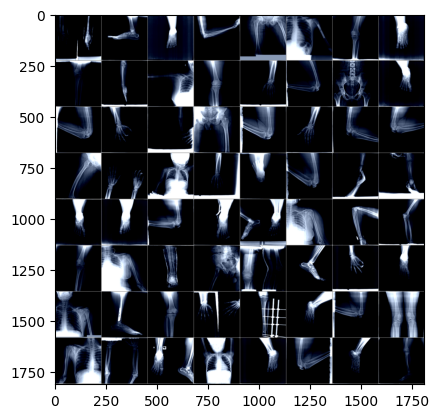

In [38]:
# Class names
class_names = ['Not Fractured', 'Fractured']

dataiter = iter(test_loader)
images, labels = next(dataiter)

# Display the images
imshow(torchvision.utils.make_grid(images))



In [42]:
# Predict labels for the batch
outputs = best_model(images)
_, predicted = torch.max(outputs, 1)

# Convert indices to class names
predicted_classes = [class_names[p] for p in predicted]
actual_classes = [class_names[l] for l in labels]


print('Actual:    ', ' '.join('%12s' % cls for cls in actual_classes))
print('Predicted: ', ' '.join('%12s' % cls for cls in predicted_classes))

Actual:     Not Fractured    Fractured    Fractured    Fractured    Fractured Not Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured Not Fractured Not Fractured    Fractured    Fractured    Fractured Not Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured Not Fractured    Fractured Not Fractured    Fractured    Fractured    Fractured    Fractured Not Fractured    Fractured Not Fractured Not Fractured    Fractured    Fractured    Fractured    Fractured Not Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured
Predicted:  Not Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured    Fractured   

In [43]:
import pandas as pd

predicted_classes = [class_names[p] for p in predicted]
actual_classes = [class_names[l] for l in labels]

results_df = pd.DataFrame({
    'Actual Label': actual_classes,
    'Predicted Label': predicted_classes
})

results_df.head(15)

,Actual Label,Predicted Label
0,Not Fractured,Not Fractured
1,Fractured,Fractured
2,Fractured,Fractured
3,Fractured,Fractured
4,Fractured,Fractured
5,Not Fractured,Fractured
6,Fractured,Fractured
7,Fractured,Fractured
8,Fractured,Fractured
9,Fractured,Fractured


In [44]:
results_df.to_csv('CV-research\resultstest_comparison.csv')